In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, splitext
from skimage import io
from skimage.color import rgb2gray
import skfuzzy as fuzz
from ipywidgets import interact, widgets
from sklearn.cluster import KMeans
from scipy.ndimage import median_filter

In [2]:
from os import listdir


input_dir = '../dataset/test'
output_dir = '../dataset/output'
gt_dir = '../dataset/groundtruth'
numImages = 80

onlyfiles = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
files = onlyfiles[0:numImages]

In [3]:
def colorSlipt (img) :
    converted_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r,greenImg,b = cv2.split(converted_img)

    plt.subplot(141), plt.imshow(converted_img, cmap='gray')
    plt.title('Original Image'), plt.axis('off')
    plt.subplot(142), plt.imshow(r, cmap='gray')
    plt.title(f'red color'), plt.axis('off')
    plt.subplot(143), plt.imshow(greenImg, cmap='gray')
    plt.title('green color'), plt.axis('off')
    plt.subplot(144), plt.imshow(b, cmap='gray')
    plt.title(f'blue color'), plt.axis('off')
    plt.show()
  
    outImg = greenImg
    return outImg

In [4]:
def compare_grey_n_green (img):
    greyImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    converted_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _,greenImg,_ = cv2.split(converted_img)

    plt.subplot(141), plt.imshow(converted_img, cmap='gray')
    plt.title('Original Image'), plt.axis('off')
    plt.subplot(142), plt.imshow(greenImg, cmap='gray')
    plt.title(f'green color'), plt.axis('off')
    plt.subplot(143), plt.imshow(greyImg, cmap='gray')
    plt.title('grey color'), plt.axis('off')
  
    plt.show()

    return;

# compare the grey and green color of the image
# the green channel will be more clear than the grey channel

In [5]:
def showSubplotImage(img, titlestr=""):
    plt.imshow(img, cmap='gray', interpolation='bicubic', vmin=0, vmax=255)
    plt.xticks([]), plt.yticks([])
    plt.title(titlestr)
    plt.show()

def setSubplotImage(img, titlestr=""):
    n = len(img)  # Number of images
    
    if n <= 6:
        # If 6 or fewer images, show in a single row
        cols = n
        rows = 1
    else:
        # Otherwise, calculate rows and columns
        cols = int(np.ceil(np.sqrt(n)))
        rows = int(np.ceil(n / cols))

    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    axs = axs.ravel()  # Flatten axes for easy indexing

    for i in range(n):
        axs[i].imshow(img[i], cmap='gray', vmin=0, vmax=255)
        axs[i].set_title(titlestr[i] if i < len(titlestr) else "")
        axs[i].axis('off')  # Turn off axes

    # Hide any unused subplots
    for i in range(n, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()
    

In [6]:
def apply_CLAHE(img, clip_limit, tile_grid_size=(15, 15)):
    # Apply CLAHE to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

def gaussian_blur(img, kernel_size, sigma):
    # Apply Gaussian smoothing
    return cv2.GaussianBlur(img, kernel_size, sigma)

def segment_retinal_vessels(image):
    green_channel = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))[1]
    clahe_img = apply_CLAHE(green_channel, 2, (13, 13))
    blurred = gaussian_blur(clahe_img, (5, 5), 1.4)


    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    gradient_magnitude = np.uint8(gradient_magnitude)

    _, thresh = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)

    reshaped_image = blurred.reshape((-1, 1))  # Flatten to 1D array
    reshaped_image = np.float32(reshaped_image)  # Convert to float32

    # Apply K-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 10
    attempts=10
    ret,labels,center=cv2.kmeans(reshaped_image,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

    clustered_image = labels.reshape(blurred.shape)

    # binary = cv2.bitwise_and(thresh, thresh)
    setSubplotImage([blurred,clustered_image],["blurred","clustered_image"])
    # Convert to binary mask: Normalize to [0, 1]
    binary_mask = (clustered_image > 0).astype('float32')  # Ensure binary (0 or 1) and float32 format

    return binary_mask


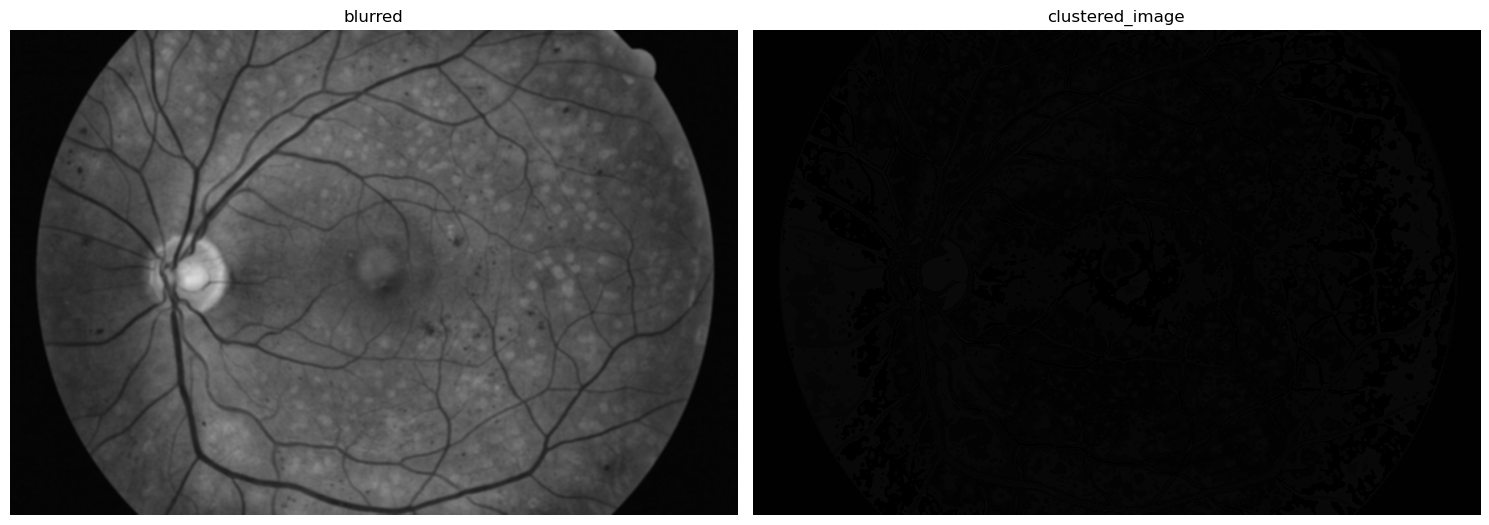

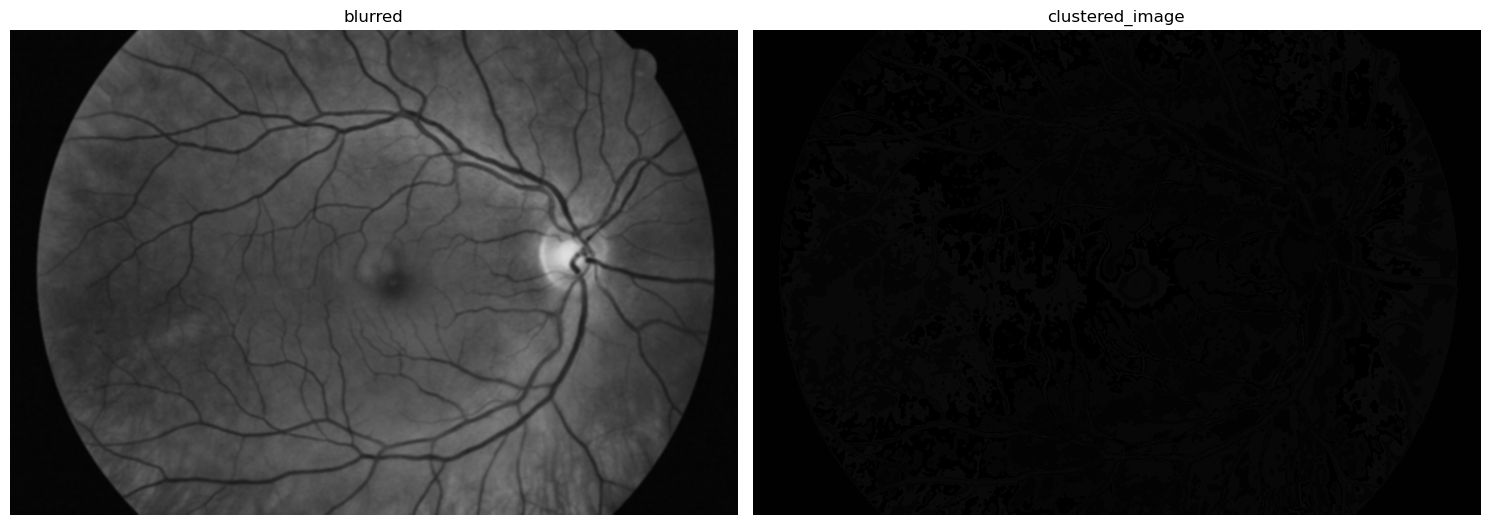

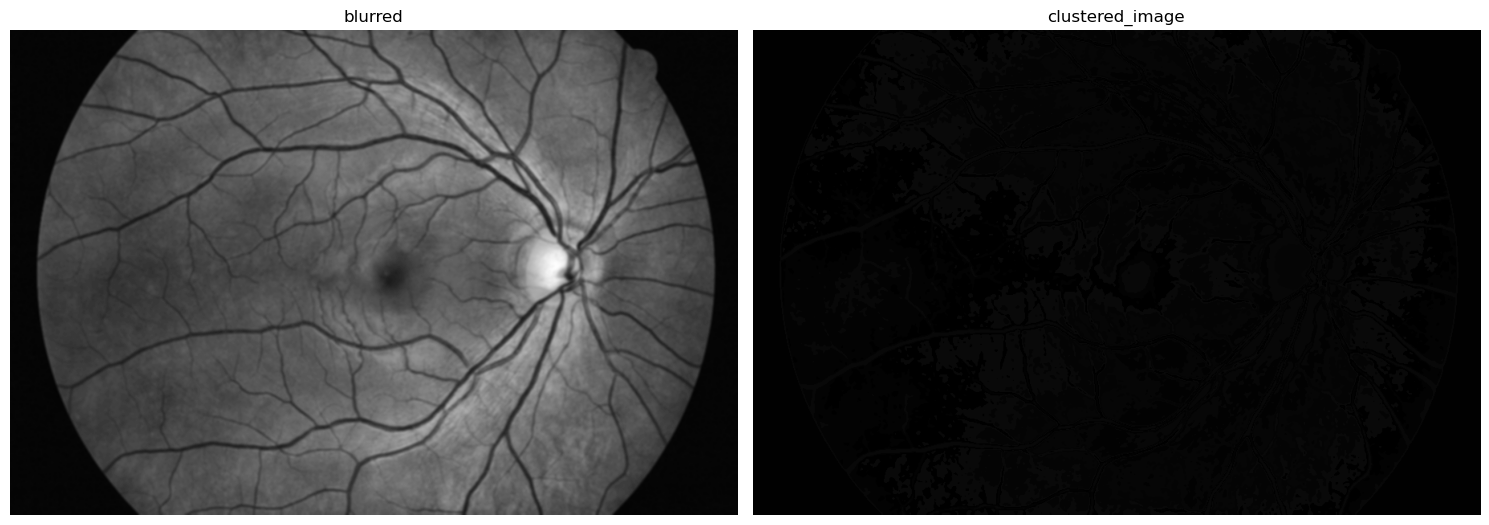

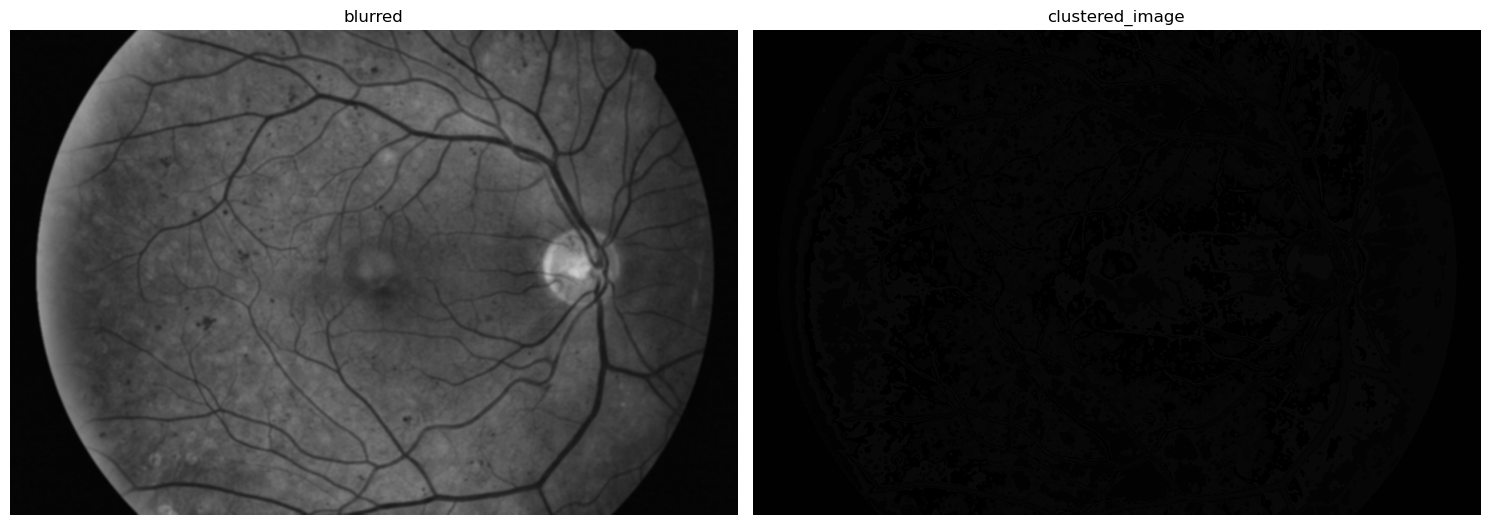

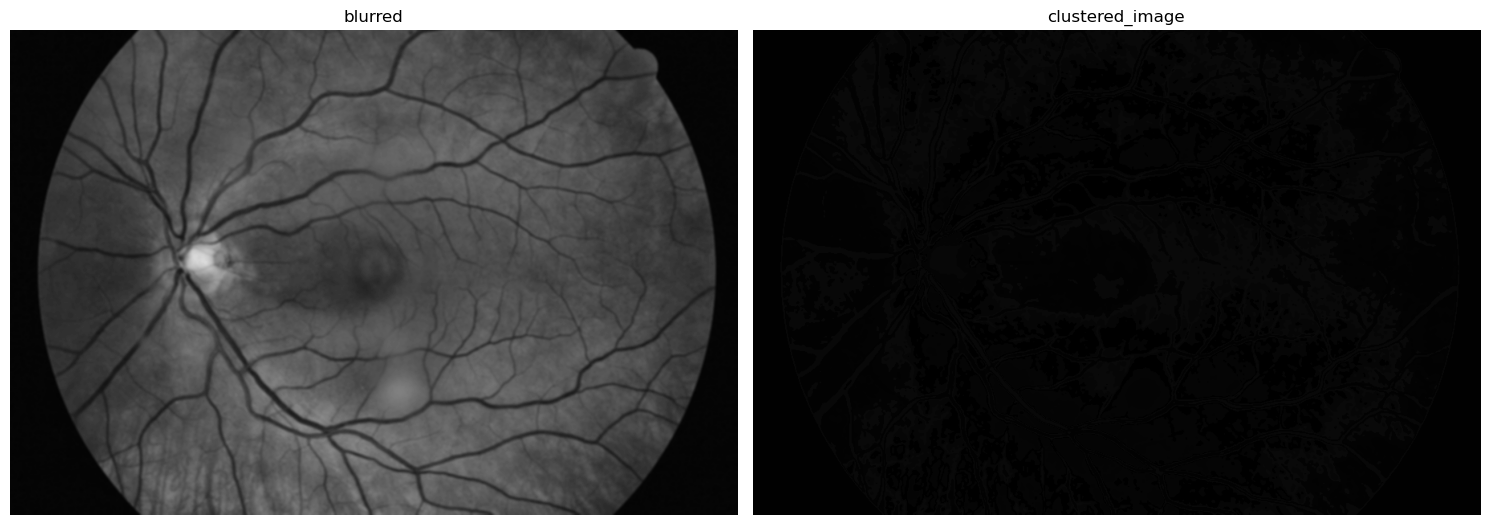

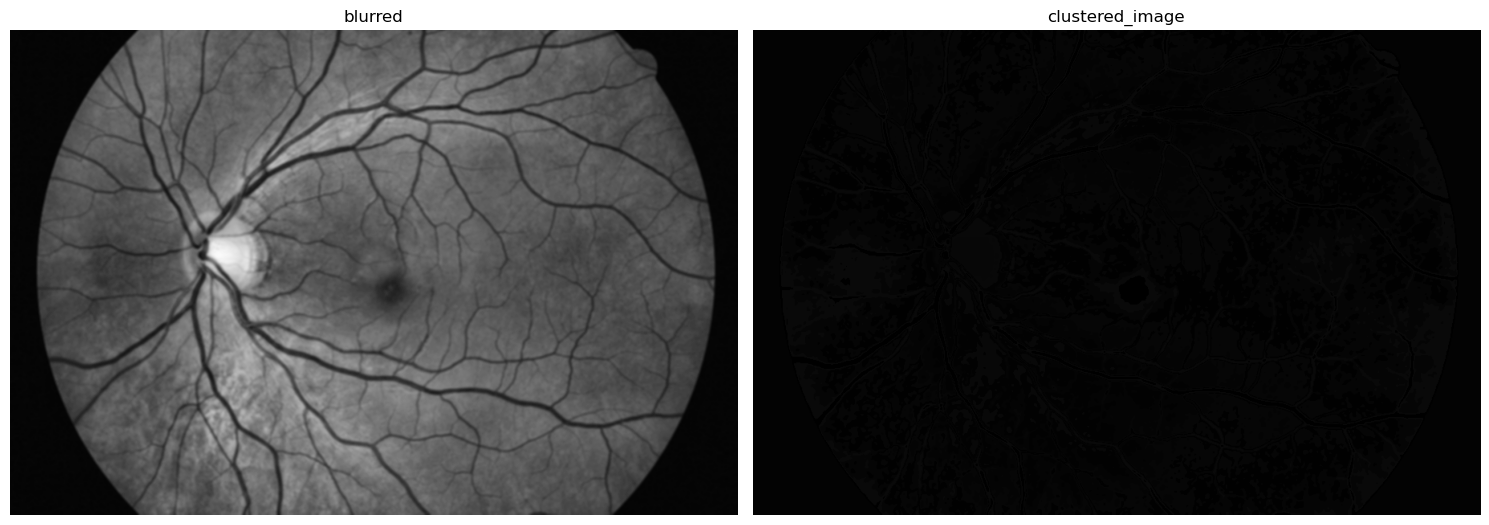

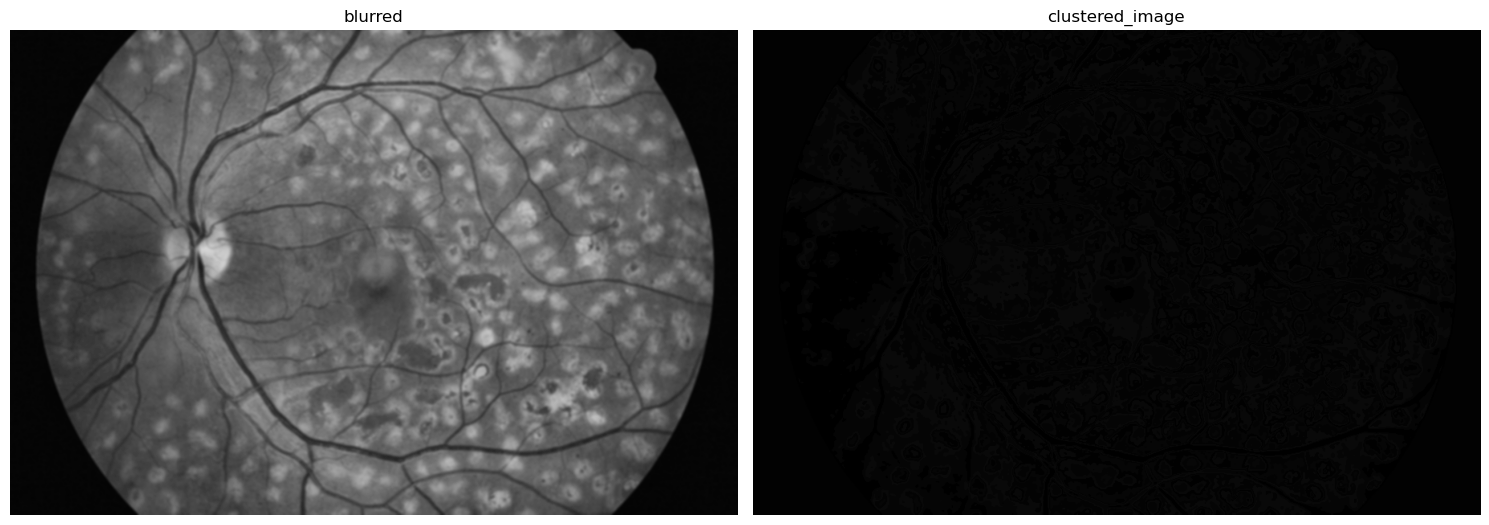

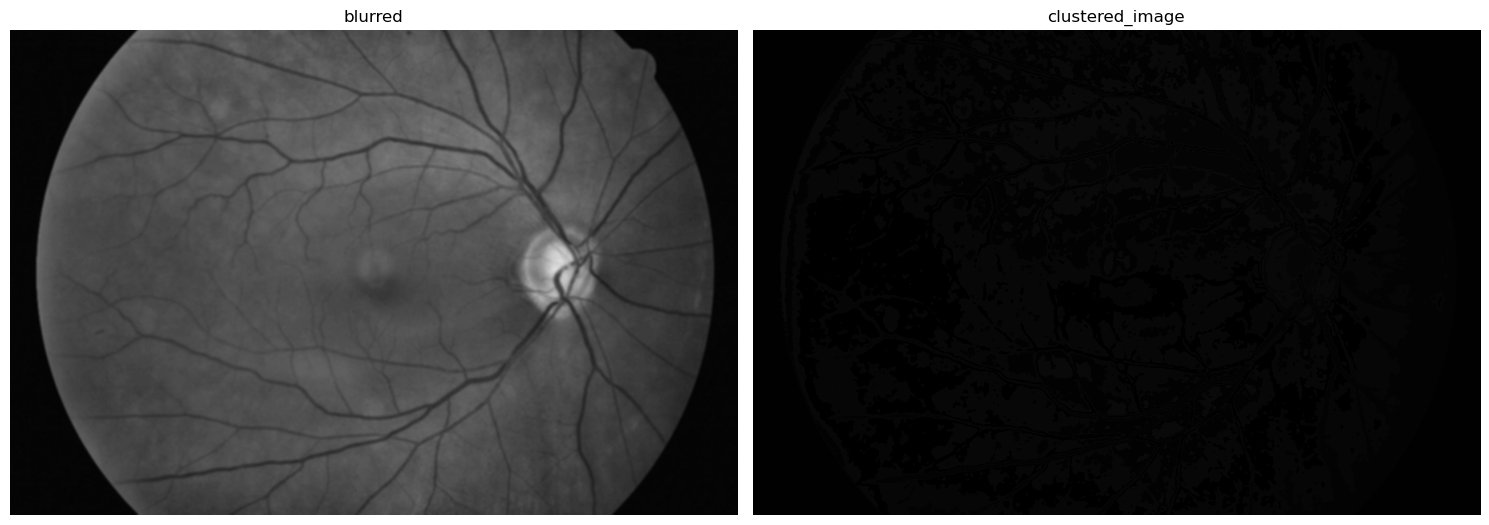

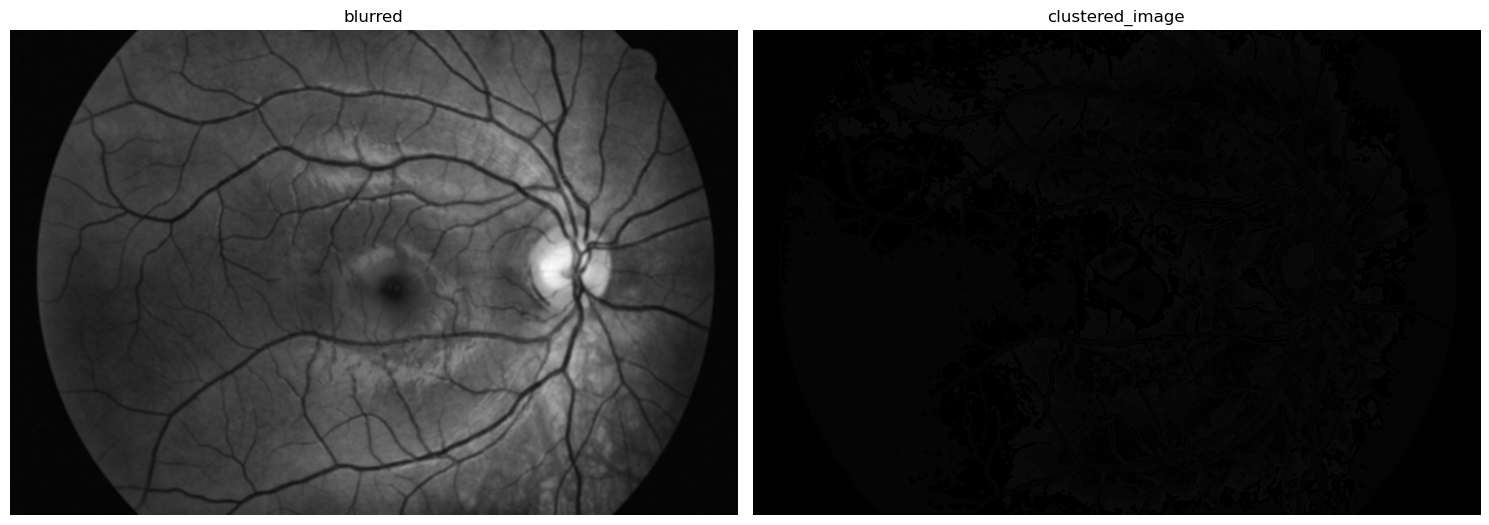

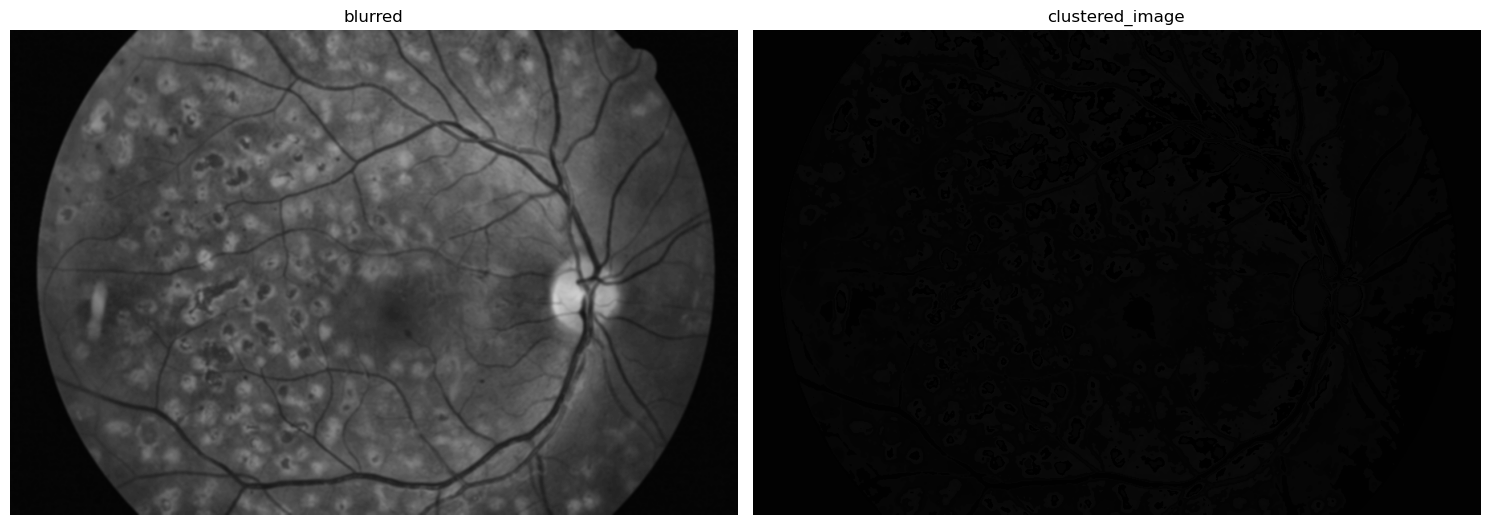

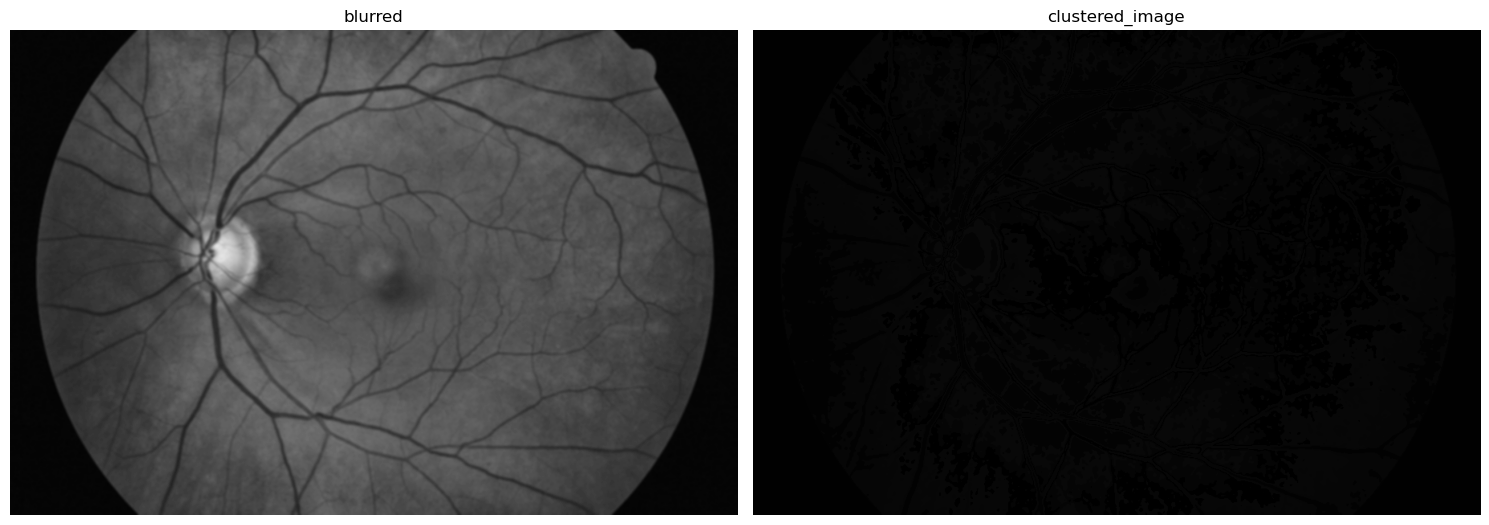

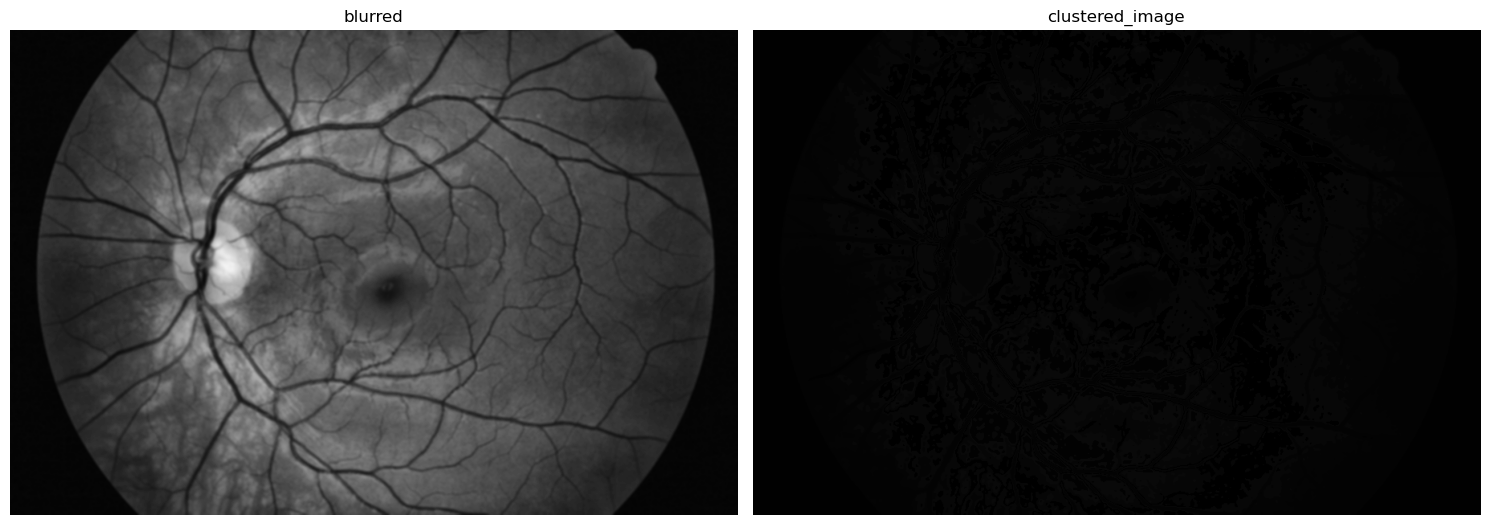

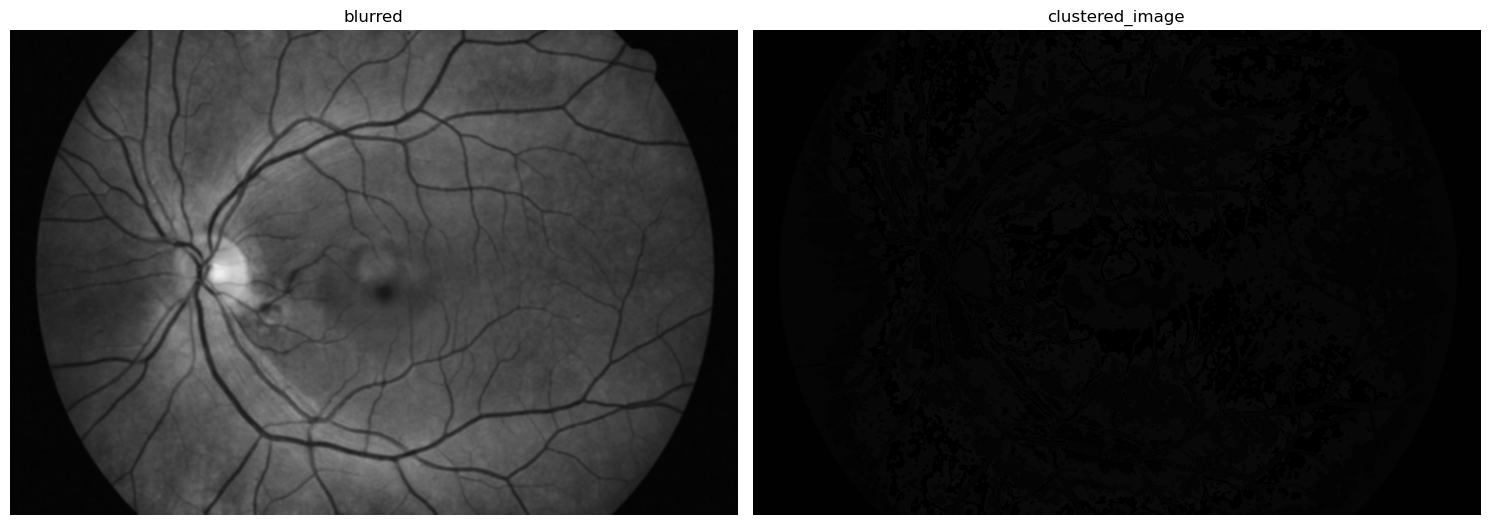

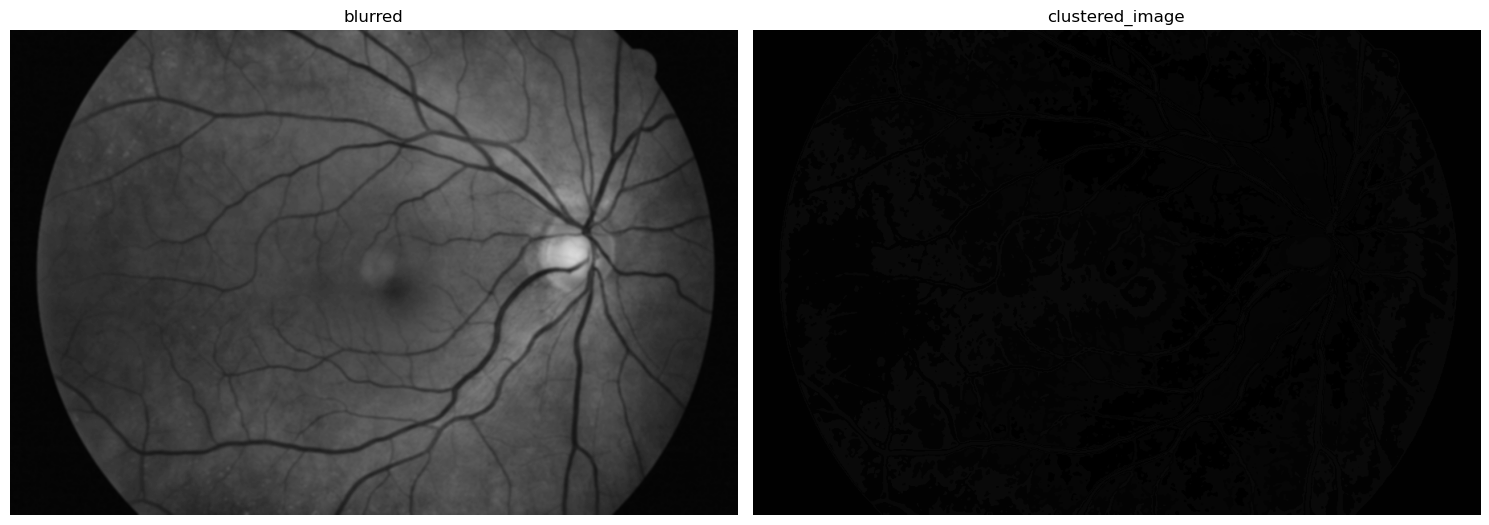

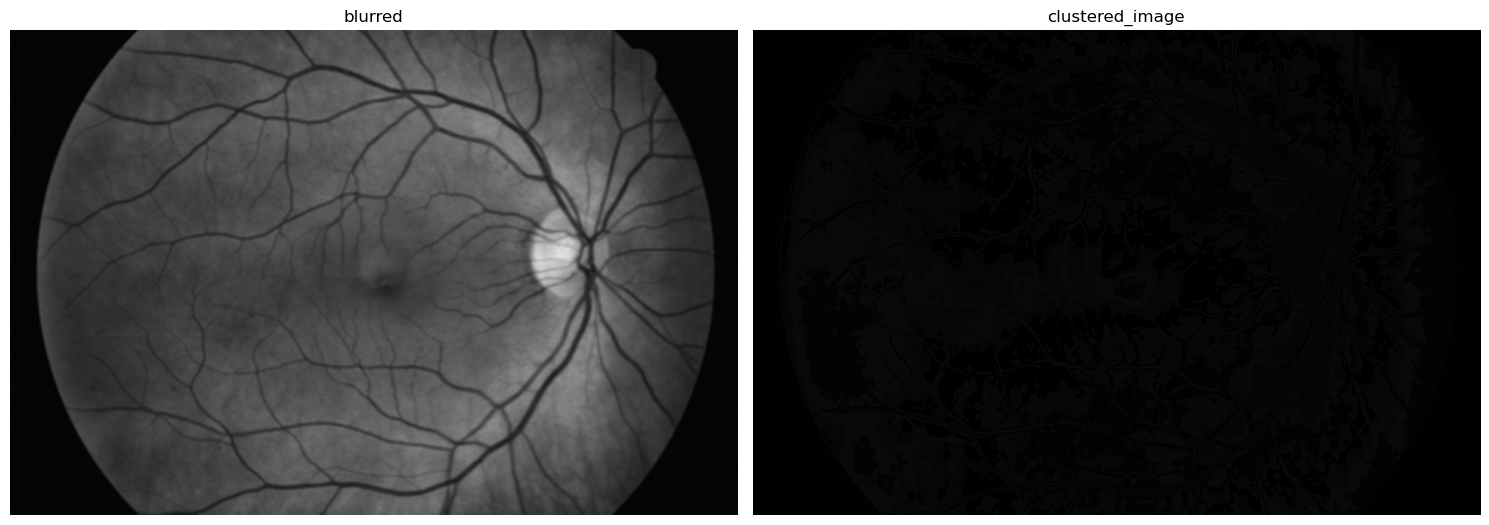

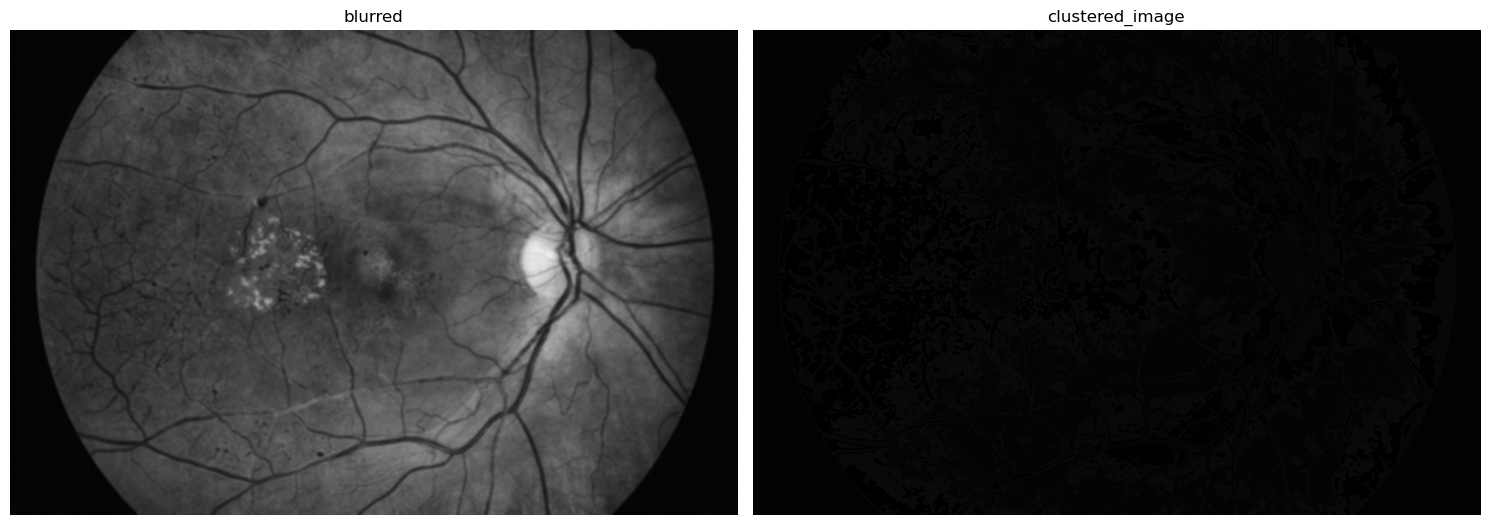

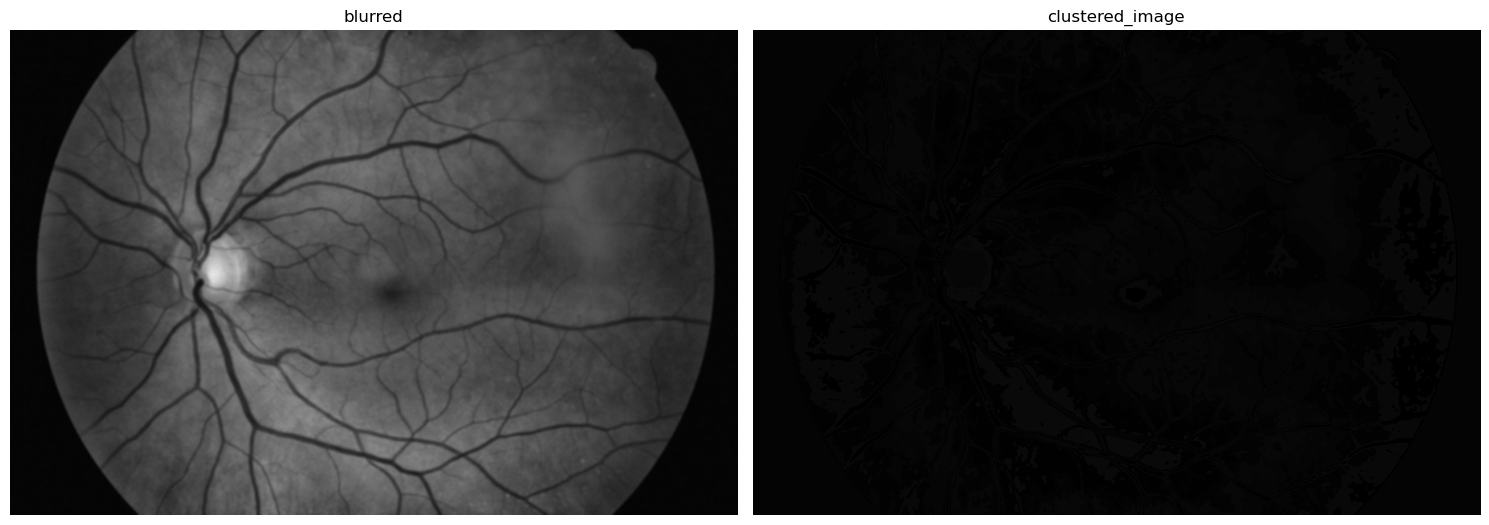

In [ ]:
for i,name in enumerate(files):
    inputImg = cv2.imread(input_dir + '/' + name)
    output = segment_retinal_vessels(inputImg)


#     # for option in morph_map.keys():
#     #     print(f"Applying Morphological Operation: {option}")
#     #     multiple_MORPH(output, kernel, 1, option)